In [38]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd
from sklearn.datasets import load_iris ##
import os
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd

## Directory

In [103]:
base_dir = ("/Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1")
os.chdir(base_dir)

dataset_dir = os.path.join(base_dir, 'img')
labels_filename = os.path.join(base_dir, 'labels.csv')



## Data Preparation

In [96]:

df = pd.read_csv(labels_filename)
df.columns=['original']
df["file_name"] = df['original'].str.split("\t").str[3]
df["faceShape_label"] = df['original'].str.split("\t").str[2]
del df['original']
    
face_shape = []
    
for shape in df.faceShape_label:
    if shape == '0':
        face_shape.append("A")
    elif shape == '1':
        face_shape.append("B")
    elif shape == '2':
        face_shape.append("C")
    elif shape == '3':
        face_shape.append("D")
    else:
        face_shape.append("E")
    
df['face_shape'] = face_shape
    



In [97]:
df

,file_name,faceShape_label,face_shape
0,0.png,4,E
1,1.png,4,E
2,2.png,3,D
3,3.png,0,A
4,4.png,2,C
...,...,...,...
9995,9995.png,2,C
9996,9996.png,3,D
9997,9997.png,2,C
9998,9998.png,2,C


In [98]:
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import models
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.optimizers import adam
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [90]:

train_data, test_data = train_test_split(df, random_state=0)
    
# Setup the data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.25,
    horizontal_flip=True,
    vertical_flip=True
    
)
    
# Get batches of training dataset from the dataframe
print("Training Dataset Preparataion")
train_generator = data_generator.flow_from_dataframe(
        dataframe = train_data, directory = dataset_dir,
        x_col = "file_name", y_col = "faceShape_label",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')
    
    # Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparataion")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = train_data, directory = dataset_dir,
        x_col = "file_name", y_col = "faceShape_label",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'validation')
    
    
    

Training Dataset Preparataion
Found 5625 validated image filenames belonging to 5 classes.

Validation Dataset Preparataion
Found 1875 validated image filenames belonging to 5 classes.


## CNN Architecture

In [91]:
# starting point 
model= models.Sequential()

# Add first convolutional block
model.add(Conv2D(24, (3, 3), activation='relu', padding='same',input_shape=(30,30,3)))
model.add(MaxPooling2D((2, 2), padding='same'))

# second block
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), padding='same'))
# third block
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# global average pooling
#model.add(GlobalAveragePooling2D())
# fully connected layer
#model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
# make predictions
model.add(Flatten())
model.add(Dense(5, activation='softmax'))




# Show a summary of the model. Check the number of trainable parameters
model.summary()




Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 30, 30, 24)        672       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 15, 15, 24)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 15, 15, 24)        5208      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 15, 15, 48)        10416     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 15, 15, 96)        41568     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 8, 8, 96)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6144)            

In [92]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# save best model automatically
mc= ModelCheckpoint('/Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

cb_list=[es,mc]


# compile model 
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [93]:
history = model.fit_generator(
        train_generator,
        epochs=25,
        steps_per_epoch=train_generator.samples // 32,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 32,
        callbacks=cb_list)

Epoch 1/25
175/175 [==============================] - 75s 428ms/step - loss: 1.5755 - accuracy: 0.2478 - val_loss: 1.2649 - val_accuracy: 0.3772

Epoch 00001: val_loss improved from inf to 1.26485, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 2/25
175/175 [==============================] - 74s 421ms/step - loss: 1.1390 - accuracy: 0.4677 - val_loss: 1.0676 - val_accuracy: 0.5708

Epoch 00002: val_loss improved from 1.26485 to 1.06761, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 3/25
175/175 [==============================] - 71s 407ms/step - loss: 0.8381 - accuracy: 0.6404 - val_loss: 0.8440 - val_accuracy: 0.7287

Epoch 00003: val_loss improved from 1.06761 to 0.84398, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 4/25
175/175 [==============================] - 65s 373ms/step - loss: 0.5626 - accuracy: 0.7722 - val_loss: 0.6469 - val_accuracy: 0.8058

Epoch 00004: val_loss im

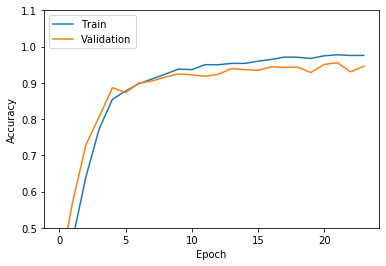

In [104]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("model_B1.png", dpi=300)

In [ ]:
# model performance


%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()